In [1]:
import numpy as np

from tqdm   import tqdm
from time   import time
from random import sample

In [6]:
n_species       = 500
species_indices = range(n_species)

n1 = 3
n2 = 2
n3 = 2
n4 = 2

sample_indices_1a = sample(species_indices, n1)
sample_indices_1b = sample(species_indices, n1)
sample_indices_2  = sample(species_indices, n2)
sample_indices_3  = sample(species_indices, n3)
sample_indices_4  = sample(species_indices, n4)

np.save("sample_indices_1a.npy", sample_indices_1a)
np.save("sample_indices_1b.npy", sample_indices_1b)
np.save("sample_indices_2.npy",  sample_indices_2)
np.save("sample_indices_3.npy",  sample_indices_3)
np.save("sample_indices_4.npy",  sample_indices_4)

atol = 1.0e-9
rtol = 1.0e-9

n_batch = 10

n_reactions = n_species * (n1**2 + n2 + n3 + n4)
n_reactions

7500

In [7]:
sample_indices_1a = np.load("sample_indices_1a.npy")
sample_indices_1b = np.load("sample_indices_1b.npy")
sample_indices_2  = np.load("sample_indices_2.npy")
sample_indices_3  = np.load("sample_indices_3.npy")
sample_indices_4  = np.load("sample_indices_4.npy")

In [9]:
# Write ODE file for scipy version
f_str  = f"import numpy as np        \n"
f_str += f"                          \n"
f_str += f"def f(t, y, args):        \n"
f_str += f"    k1, k2, k3, k4 = args \n"
# f_str += f"    f = np.empty_like(y)  \n"
f_str += f"    f = np.empty({n_species})  \n"

for i in tqdm(species_indices):
    eqn = f"    f[{i}] ="
    # y_j + y_l -> y_i
    for j in sample_indices_1a:
        for l in sample_indices_1b:
            eqn += f" +k1[{i},{j}]*y[{j}]*y[{l}]"
    # Creation?
    for m in sample_indices_2:
        eqn += f" +k2[{m}]*y[{m}]"
    # Destruction?
    for r in sample_indices_3:
        eqn += f" -k3[{i},{r}]*y[{i}]*y[{r}]"
    # Destruction?
    for s in sample_indices_4:
        eqn += f" -k4[{s}]*y[{i}]"
    eqn += "\n"
    f_str   += eqn
f_str += f"    return f"

with open('f_scipy.py', "w") as file:
    file.write(f_str)

100%|██████████| 500/500 [00:00<00:00, 37858.83it/s]

In [8]:
# Write ODE file for torch version
f_str  = f"import torch                \n"
f_str += f"                            \n"
f_str += f"def f(t, y, args):          \n"
f_str += f"    k1, k2, k3, k4 = args   \n"
f_str += f"    f = torch.empty_like(y) \n"

for i in tqdm(species_indices):
    eqn = f"    f[:,{i}] ="
    # y_j + y_l -> y_i
    for j in sample_indices_1a:
        for l in sample_indices_1b:
            eqn += f" +k1[{i},{j}]*y[:,{j}]*y[:,{l}]"
    # Creation?
    for m in sample_indices_2:
        eqn += f" +k2[{m}]*y[:,{m}]"
    # Destruction?
    for r in sample_indices_3:
        eqn += f" -k3[{i},{r}]*y[:,{i}]*y[:,{r}]"
    # Destruction?
    for s in sample_indices_4:
        eqn += f" -k4[{s}]*y[:,{i}]"
    eqn += "\n"
    f_str   += eqn
f_str += f"    return f"

with open('f_torch.py', "w") as file:
    file.write(f_str)

100%|██████████| 500/500 [00:00<00:00, 33886.25it/s]

In [6]:
from f_scipy import f as f_scipy
from f_torch import f as f_torch

In [7]:
# Initial conditions
t0 = 0.0
y0 = np.random.rand(n_species).astype(np.float64)

# End time and time step
t1 = 1.0e-1
dt = t1

t_eval = np.arange(t0, t1+1.0e-9, step=dt, dtype=np.float64)

# # Rate coefficients
# k1 = np.random.rand(n_species, n_species).astype(np.float64)
# k2 = np.random.rand(n_species           ).astype(np.float64)
# k3 = np.random.rand(n_species, n_species).astype(np.float64)
# k4 = np.random.rand(n_species           ).astype(np.float64)

# np.save("k1.npy", k1)
# np.save("k2.npy", k2)
# np.save("k3.npy", k3)
# np.save("k4.npy", k4)

k1 = np.load("k1.npy")
k2 = np.load("k2.npy")
k3 = np.load("k3.npy")
k4 = np.load("k4.npy")

In [8]:
from scipy.integrate import ode

In [9]:
# Ground truth (reference)
args = (k1, k2, k3, k4)

# Setup the solver
solver = ode(f_scipy)
solver.set_integrator(
    "vode",
    method        = "bdf",
    with_jacobian = True,
    atol          = 1.0e-16,
    rtol          = 1.0e-16
)
solver.set_initial_value(y0, t0)
solver.set_f_params(args)

# Run solver
wct =- time()
solution = solver.integrate(dt)
wct += time()
    
if not solver.successful():
    raise RuntimeError("Solver issue!")

yt_scipy = solution
yt_truth = yt_scipy
wct

7.885047912597656

In [44]:
def relative_diff(a, b):
    return np.abs(2.0*(a-b)/(a+b))

In [ ]:
# Benchmark scipy solvers
n_test = 20

atols = [1.0e-16 * 10**i for i in range(16)]
rtols = [1.0e-16 * 10**i for i in range(16)]

wcts = []
avgs = []
maxs = []

for atol, rtol in tqdm(zip(atols, rtols)):
    wcts.append(np.zeros(n_test))
    avgs.append(np.zeros(n_test))
    maxs.append(np.zeros(n_test))

    for i in range(n_test):
        
        args = (k1, k2, k3, k4)

        # Setup the solver
        solver = ode(f_scipy)
        solver.set_integrator(
            "vode",
            method        = "bdf",
            with_jacobian = True,
            atol          = atol,
            rtol          = rtol
        )
        solver.set_initial_value(y0, t0)
        solver.set_f_params(args)

        # Run solver
        wct =- time()
        solution = solver.integrate(dt)
        wct += time()
    
        if not solver.successful():
            raise RuntimeError("Solver issue!")

        yt_scipy = solution
        
        rel_diff = relative_diff(yt_scipy, yt_truth)
        
        wcts[-1][i] = wct
        avgs[-1][i] = np.mean(rel_diff)
        maxs[-1][i] = np.max (rel_diff)
        
vj_wcts_avg = np.array([np.mean(w) for w in wcts])
vj_wcts_max = np.array([np.max (w) for w in wcts])
vj_avgs     = np.array([np.mean(a) for a in avgs])
vj_maxs     = np.array([np.max (m) for m in maxs])

np.save("vj_wcts_avg.npy", vj_wcts_avg)
np.save("vj_wcts_max.npy", vj_wcts_max)
np.save("vj_avgs.npy",     vj_avgs)
np.save("vj_maxs.npy",     vj_maxs)

4it [08:15, 113.08s/it]

In [ ]:
# Benchmark scipy solvers
n_test = 20

atols = [1.0e-16 * 10**i for i in range(16)]
rtols = [1.0e-16 * 10**i for i in range(16)]

wcts = []
avgs = []
maxs = []

for atol, rtol in tqdm(zip(atols, rtols)):
    wcts.append(np.zeros(n_test))
    avgs.append(np.zeros(n_test))
    maxs.append(np.zeros(n_test))

    for i in range(n_test):
        
        args = (k1, k2, k3, k4)

        # Setup the solver
        solver = ode(f_scipy)
        solver.set_integrator(
            "vode",
            method        = "bdf",
            with_jacobian = False,
            atol          = atol,
            rtol          = rtol
        )
        solver.set_initial_value(y0, t0)
        solver.set_f_params(args)

        # Run solver
        wct =- time()
        solution = solver.integrate(dt)
        wct += time()
    
        if not solver.successful():
            raise RuntimeError("Solver issue!")

        yt_scipy = solution
        
        rel_diff = relative_diff(yt_scipy, yt_truth)
        
        wcts[-1][i] = wct
        avgs[-1][i] = np.mean(rel_diff)
        maxs[-1][i] = np.max (rel_diff)
        
v_wcts_avg = np.array([np.mean(w) for w in wcts])
v_wcts_max = np.array([np.max (w) for w in wcts])
v_avgs     = np.array([np.mean(a) for a in avgs])
v_maxs     = np.array([np.max (m) for m in maxs])

np.save("v_wcts_avg.npy", v_wcts_avg)
np.save("v_wcts_max.npy", v_wcts_max)
np.save("v_avgs.npy",     v_avgs)
np.save("v_maxs.npy",     v_maxs)

In [ ]:
# Benchmark scipy solvers
n_test = 20

atols = [1.0e-13 * 10**i for i in range(13)]
rtols = [1.0e-13 * 10**i for i in range(13)]

wcts = []
avgs = []
maxs = []

for atol, rtol in tqdm(zip(atols, rtols)):
    wcts.append(np.zeros(n_test))
    avgs.append(np.zeros(n_test))
    maxs.append(np.zeros(n_test))

    for i in range(n_test):
        
        args = (k1, k2, k3, k4)

        # Setup the solver
        solver = ode(f_scipy)
        solver.set_integrator(
            "lsoda",
            atol          = atol,
            rtol          = rtol
        )
        solver.set_initial_value(y0, t0)
        solver.set_f_params(args)

        # Run solver
        wct =- time()
        solution = solver.integrate(dt)
        wct += time()
    
        if not solver.successful():
            raise RuntimeError("Solver issue!")

        yt_scipy = solution
        
        rel_diff = relative_diff(yt_scipy, yt_truth)
        
        wcts[-1][i] = wct
        avgs[-1][i] = np.mean(rel_diff)
        maxs[-1][i] = np.max (rel_diff)
        
l_wcts_avg = np.array([np.mean(w) for w in wcts])
l_wcts_max = np.array([np.max (w) for w in wcts])
l_avgs     = np.array([np.mean(a) for a in avgs])
l_maxs     = np.array([np.max (m) for m in maxs])

np.save("l_wcts_avg.npy", l_wcts_avg)
np.save("l_wcts_max.npy", l_wcts_max)
np.save("l_avgs.npy",     l_avgs)
np.save("l_maxs.npy",     l_maxs)

In [ ]:
# Benchmark scipy solvers
n_test = 20

atols = [1.0e-13 * 10**i for i in range(13)]
rtols = [1.0e-13 * 10**i for i in range(13)]

wcts = []
avgs = []
maxs = []

for atol, rtol in tqdm(zip(atols, rtols)):
    wcts.append(np.zeros(n_test))
    avgs.append(np.zeros(n_test))
    maxs.append(np.zeros(n_test))

    for i in range(n_test):
        
        args = (k1, k2, k3, k4)

        # Setup the solver
        solver = ode(f_scipy)
        solver.set_integrator(
            "dopri5",
            atol          = atol,
            rtol          = rtol
        )
        solver.set_initial_value(y0, t0)
        solver.set_f_params(args)

        # Run solver
        wct =- time()
        solution = solver.integrate(dt)
        wct += time()
    
        if not solver.successful():
            raise RuntimeError("Solver issue!")

        yt_scipy = solution
        
        rel_diff = relative_diff(yt_scipy, yt_truth)
        
        wcts[-1][i] = wct
        avgs[-1][i] = np.mean(rel_diff)
        maxs[-1][i] = np.max (rel_diff)
        
d_wcts_avg = np.array([np.mean(w) for w in wcts])
d_wcts_max = np.array([np.max (w) for w in wcts])
d_avgs     = np.array([np.mean(a) for a in avgs])
d_maxs     = np.array([np.max (m) for m in maxs])

np.save("d_wcts_avg.npy", d_wcts_avg)
np.save("d_wcts_max.npy", d_wcts_max)
np.save("d_avgs.npy",     d_avgs)
np.save("d_maxs.npy",     d_maxs)

In [ ]:
# Benchmark scipy solvers
n_test = 20

atols = [1.0e-13 * 10**i for i in range(13)]
rtols = [1.0e-13 * 10**i for i in range(13)]

wcts = []
avgs = []
maxs = []

for atol, rtol in tqdm(zip(atols, rtols)):
    wcts.append(np.zeros(n_test))
    avgs.append(np.zeros(n_test))
    maxs.append(np.zeros(n_test))

    for i in range(n_test):
        
        args = (k1, k2, k3, k4)

        # Setup the solver
        solver = ode(f_scipy)
        solver.set_integrator(
            "dop853",
            atol          = atol,
            rtol          = rtol
        )
        solver.set_initial_value(y0, t0)
        solver.set_f_params(args)

        # Run solver
        wct =- time()
        solution = solver.integrate(dt)
        wct += time()
    
        if not solver.successful():
            raise RuntimeError("Solver issue!")

        yt_scipy = solution
        
        rel_diff = relative_diff(yt_scipy, yt_truth)
        
        wcts[-1][i] = wct
        avgs[-1][i] = np.mean(rel_diff)
        maxs[-1][i] = np.max (rel_diff)
        
d8_wcts_avg = np.array([np.mean(w) for w in wcts])
d8_wcts_max = np.array([np.max (w) for w in wcts])
d8_avgs     = np.array([np.mean(a) for a in avgs])
d8_maxs     = np.array([np.max (m) for m in maxs])

np.save("d8_wcts_avg.npy", d8_wcts_avg)
np.save("d8_wcts_max.npy", d8_wcts_max)
np.save("d8_avgs.npy",     d8_avgs)
np.save("d8_maxs.npy",     d8_maxs)

In [54]:
vj_wcts_avg = np.load("vj_wcts_avg.npy")
vj_wcts_max = np.load("vj_wcts_max.npy")
vj_avgs     = np.load("vj_avgs.npy")
vj_maxs     = np.load("vj_maxs.npy")

v_wcts_avg = np.load("v_wcts_avg.npy")
v_wcts_max = np.load("v_wcts_max.npy")
v_avgs     = np.load("v_avgs.npy")
v_maxs     = np.load("v_maxs.npy")

l_wcts_avg = np.load("l_wcts_avg.npy")
l_wcts_max = np.load("l_wcts_max.npy")
l_avgs     = np.load("l_avgs.npy")
l_maxs     = np.load("l_maxs.npy")

d_wcts_avg = np.load("d_wcts_avg.npy")
d_wcts_max = np.load("d_wcts_max.npy")
d_avgs     = np.load("d_avgs.npy")
d_maxs     = np.load("d_maxs.npy")

d8_wcts_avg = np.load("d8_wcts_avg.npy")
d8_wcts_max = np.load("d8_wcts_max.npy")
d8_avgs     = np.load("d8_avgs.npy")
d8_maxs     = np.load("d8_maxs.npy")

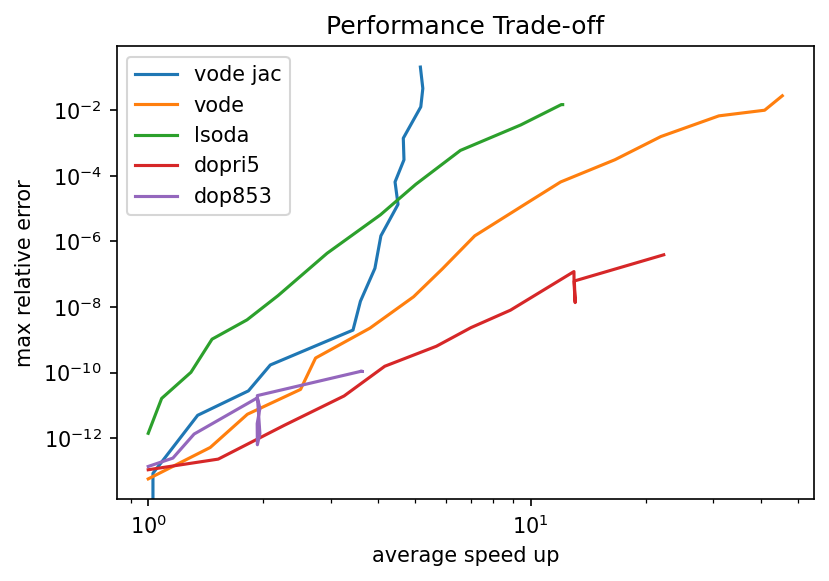

In [55]:
import matplotlib.pyplot as plt

plt.figure(dpi=150)
plt.title("Performance Trade-off")
# plt.scatter(np.max(wcts_avg)/wcts_avg, avgs, label="mean")
plt.plot(np.max(vj_wcts_avg)/vj_wcts_avg, vj_maxs, label="vode jac")
plt.plot(np.max( v_wcts_avg)/ v_wcts_avg,  v_maxs, label="vode")
plt.plot(np.max( l_wcts_avg)/ l_wcts_avg,  l_maxs, label="lsoda")
plt.plot(np.max( d_wcts_avg)/ d_wcts_avg,  d_maxs, label="dopri5")
plt.plot(np.max(d8_wcts_avg)/d8_wcts_avg, d8_maxs, label="dop853")
plt.xlabel("average speed up")
plt.ylabel("max relative error")
plt.xscale('log')
plt.yscale('log')
plt.legend()

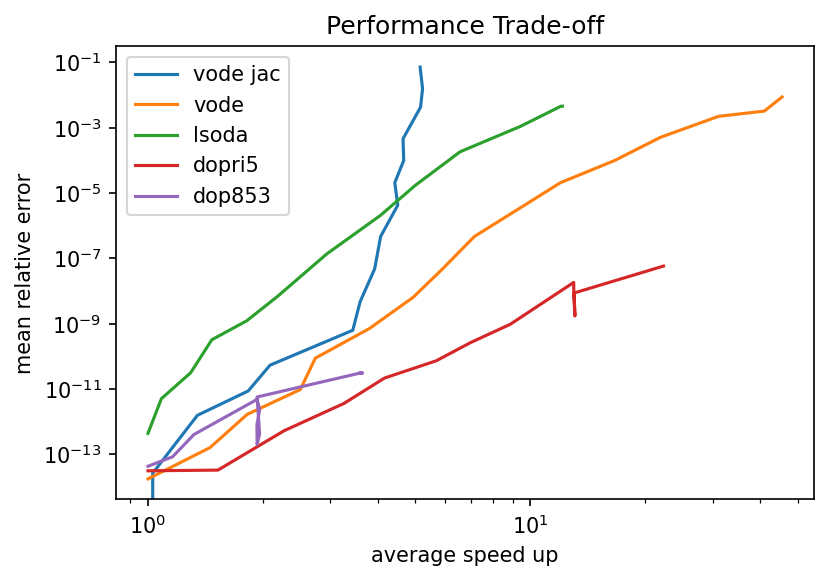

In [56]:
import matplotlib.pyplot as plt

plt.figure(dpi=150)
plt.title("Performance Trade-off")
# plt.scatter(np.max(wcts_avg)/wcts_avg, avgs, label="mean")
plt.plot(np.max(vj_wcts_avg)/vj_wcts_avg, vj_avgs, label="vode jac")
plt.plot(np.max( v_wcts_avg)/ v_wcts_avg,  v_avgs, label="vode")
plt.plot(np.max( l_wcts_avg)/ l_wcts_avg,  l_avgs, label="lsoda")
plt.plot(np.max( d_wcts_avg)/ d_wcts_avg,  d_avgs, label="dopri5")
plt.plot(np.max(d8_wcts_avg)/d8_wcts_avg, d8_avgs, label="dop853")
plt.xlabel("average speed up")
plt.ylabel("mean relative error")
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [57]:
d8_avgs

array([4.36028501e-14, 8.52452843e-14, 4.06373938e-13, 4.85146561e-12,
       2.34957077e-12, 8.14203176e-13, 2.02096649e-13, 4.23286856e-13,
       5.73778154e-12, 3.11294429e-11, 3.11294429e-11, 3.11294429e-11,
       3.11294429e-11])

In [23]:
%time solution = solver.integrate(dt)

CPU times: user 105 µs, sys: 76 µs, total: 181 µs
Wall time: 154 µs


In [17]:
solver.set_initial_value(y0, t0)
solver.set_f_params(args)

%timeit solution = solver.integrate(dt)

The slowest run took 5.33 times longer than the fastest. This could mean that an intermediate result is being cached.
28.5 µs ± 24.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
import torch
import torchode as to

# Setup solver
term                 = to.ODETerm(f_torch, with_args=True)
step_method          = to.Tsit5(term=term)
# step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=term)
step_size_controller = to.PIDController(atol=atol, rtol=rtol, pcoeff=0.2, icoeff=0.5, dcoeff=0.0, term=term)
solver               = to.AutoDiffAdjoint(step_method, step_size_controller)

jit_solver = torch.compile(solver)

problem = to.InitialValueProblem(
    y0     = torch.from_numpy(y0    ).view((1,-1)),
    t_eval = torch.from_numpy(t_eval).view((1,-1)),
)

args = (
    torch.from_numpy(k1),
    torch.from_numpy(k2),
    torch.from_numpy(k3),
    torch.from_numpy(k4)
)

# Run solver
wct =- time()
solution = jit_solver.solve(problem, args=args)
wct += time()
print("elapsed time:", wct)
print("success?     ", solution.status.item()==0)

yt_torch = solution.ys[0][-1].numpy()

elapsed time: 16.468475580215454
success?      True


In [9]:
# Maximum absolute relative difference
np.max(np.abs(2.0 * (yt_scipy - yt_torch) / (yt_scipy + yt_torch)))

1.831381547245469e-07

In [10]:
yt_scipy[1]

1.2885065936194973

In [11]:
yt_torch[1]

1.2885064636677932

In [12]:
y0[1]

0.8906423213738007

In [13]:
# Use torchode batch parallelism to generate multiple models at once?
import torch
import torchode as to

# Setup solver
term                 = to.ODETerm(f_torch, with_args=True)
step_method          = to.Tsit5(term=term)
# step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=term)
step_size_controller = to.PIDController(atol=atol, rtol=rtol, pcoeff=0.2, icoeff=0.5, dcoeff=0.0, term=term)
solver               = to.AutoDiffAdjoint(step_method, step_size_controller)

jit_solver = torch.compile(solver)


y0_batch = torch.rand(n_batch, n_species, dtype=torch.float64)

t_eval_batch    = torch.empty(n_batch, t_eval.shape[0])
t_eval_batch[:] = torch.from_numpy(t_eval)


problem = to.InitialValueProblem(
    y0     = y0_batch,
    t_eval = t_eval_batch,
)

args = (
    torch.from_numpy(k1),
    torch.from_numpy(k2),
    torch.from_numpy(k3),
    torch.from_numpy(k4)
)

# Run solver
wct =- time()
solution = jit_solver.solve(problem, args=args)
wct += time()
print("elapsed time:", wct)
print("success?     ", solution.status.item()==0)

yt_torch = solution.ys[0][-1].numpy()

elapsed time: 116.50065684318542


RuntimeError: a Tensor with 10 elements cannot be converted to Scalar

In [19]:
n_batch = 10



torch.Size([10, 500])

In [20]:
t_eval

array([0. , 0.5])

In [30]:
t_eval_batch

tensor([[0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000]])

In [27]:
t_eval.shape[0]

2

In [ ]:
# petsc
from petsc